**Utilicé IA para completar algunas partes de esta tarea, que explicaré en la parte del código.**

A través de chatgpt e Internet, aprendí que "sklearn.neighbors, KNeighborsRegressor" es un muy buen módulo para completar el método de estimación_vecino_más cercano.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor

##### Descargar datos

In [2]:
df_holocene = pd.read_csv('df_empirical_Holocene.csv')
df_lgm = pd.read_csv('df_empirical_LGM.csv')

##### El metodo distance_geodesic usando la formula 

**"Rarc cos (sen(ϕ1) sen(ϕ2) + cos(ϕ1) cos(ϕ2) cos(λ2 − λ1))"**

In [3]:
def distance_geodesic(phi1, lambda1, phi2, lambda2, R=6371):
    phi1, lambda1, phi2, lambda2 = map(np.radians, [phi1, lambda1, phi2, lambda2])
    term1 = np.sin(phi1) * np.sin(phi2)
    term2 = np.cos(phi1) * np.cos(phi2) * np.cos(lambda2 - lambda1)
    distance = R * np.arccos(term1 + term2)
    return distance

#### El metodo distance_euclidean

In [4]:
def distance_euclidean(x, y):
    return np.sqrt((x[0] - y[0])**2 + (x[1] - y[1])**2)

#### Aplicar el metodo de vecinos cercanos con distancia geodesica

In [5]:
def nearest_neighbour_estimation(df, x, k, dist='euclidean'):
    if dist == 'geodesic':
        dist_metric = lambda a, b: distance_geodesic(a[1], a[0], b[1], b[0])
    else:
        dist_metric = distance_euclidean
    
    X = df[['lon', 'lat']].values
    y = df['log_dep'].values
    neigh = KNeighborsRegressor(n_neighbors=k, metric=dist_metric)
    neigh.fit(X, y)
    return neigh.predict([x])[0]

#### Generación de red global

In [6]:
longitude_to_predict = np.linspace(-180, 180, 121)
latitude_to_predict = np.linspace(-90, 90, 61)
xx, yy = np.meshgrid(longitude_to_predict, latitude_to_predict)
XYpairs = np.vstack([xx.ravel(), yy.ravel()]).T

#### Usando el metodo geodesic y euclidean para "df_holocene" y "df_lgm". Son dos casos

In [7]:
estimations_geodesic_holocene = [nearest_neighbour_estimation(df_holocene, (lon, lat), 5, 'geodesic') for lon, lat in XYpairs]
estimations_euclidean_holocene = [nearest_neighbour_estimation(df_holocene, (lon, lat), 5, 'euclidean') for lon, lat in XYpairs]
estimations_geodesic_lgm = [nearest_neighbour_estimation(df_lgm, (lon, lat), 5, 'geodesic') for lon, lat in XYpairs]
estimations_euclidean_lgm = [nearest_neighbour_estimation(df_lgm, (lon, lat), 5, 'euclidean') for lon, lat in XYpairs]

#### Visualzar los dos metodos.
**Para la parte de visualización, utilicé la ayuda de ChatGPT porque no tengo suficiente conocimiento para crear ese tipo de gráfico. Le pregunté acerca del color, estructura, forma del gráfico, etc. También hice el gráfico euclidiano porque así se puede comparar mejor.**

In [8]:
def plot_comparison(est_geo, est_eucl, title, filename):
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    
    for i, est in enumerate([est_geo, est_eucl]):
        world.boundary.plot(ax=ax[i], linewidth=0.4, color="black")
        scatter = ax[i].scatter(XYpairs[:, 0], XYpairs[:, 1], c=est, cmap='viridis', s=10)
        ax[i].set_xlim([-180, 180])
        ax[i].set_ylim([-90, 90])
        ax[i].set_title('Geodesic Distance Estimations' if i == 0 else 'Euclidean Distance Estimations')
        cbar = fig.colorbar(scatter, ax=ax[i], orientation='vertical', fraction=0.02)
        cbar.set_label('Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]', rotation=270, labelpad=15)

    fig.suptitle(title, y=0.8)
    plt.savefig(f"{filename}.png", bbox_inches='tight', dpi=300)
    plt.show()


C:\Users\nsanc\AppData\Local\Temp\ipykernel_20752\2906501263.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


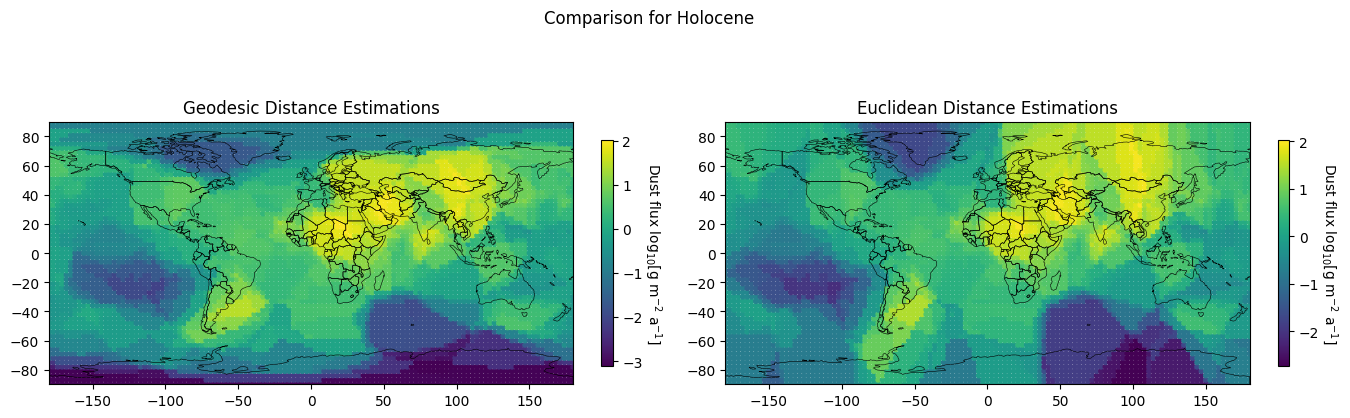

C:\Users\nsanc\AppData\Local\Temp\ipykernel_20752\2906501263.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


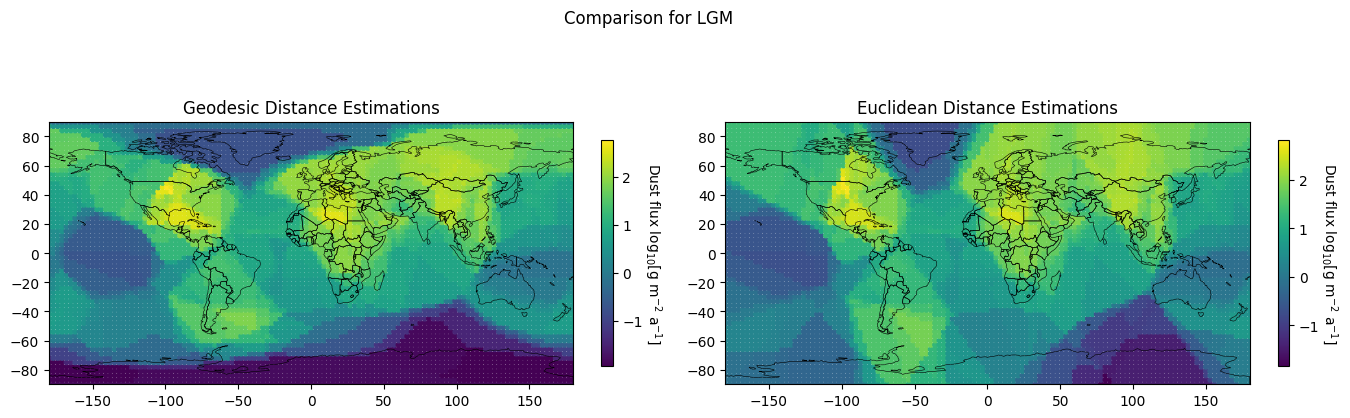

In [72]:
plot_comparison(estimations_geodesic_holocene, estimations_euclidean_holocene, 'Comparison for Holocene', 'comparison_holocene')
plot_comparison(estimations_geodesic_lgm, estimations_euclidean_lgm, 'Comparison for LGM', 'comparison_lgm')

#### Visualizar la diferencia entre dos metodos

In [10]:

def plot_differences(differences, title, filename):
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    fig, ax = plt.subplots(figsize=(12, 8))
    world.boundary.plot(ax=ax, linewidth=0.5, edgecolor='black')
    scatter = ax.scatter(XYpairs[:, 0], XYpairs[:, 1], c=differences, cmap='coolwarm', marker='o')
    cbar = fig.colorbar(scatter, ax=ax, orientation='horizontal', fraction=0.036, pad=0.1, aspect=30)
    cbar.set_label('Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]', labelpad=10)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(title)
    plt.savefig(f"{filename}.png")
    plt.show()

In [11]:
differences_holocene = np.array(estimations_geodesic_holocene) - np.array(estimations_euclidean_holocene)
differences_lgm = np.array(estimations_geodesic_lgm) - np.array(estimations_euclidean_lgm)

C:\Users\nsanc\AppData\Local\Temp\ipykernel_40032\1683112547.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


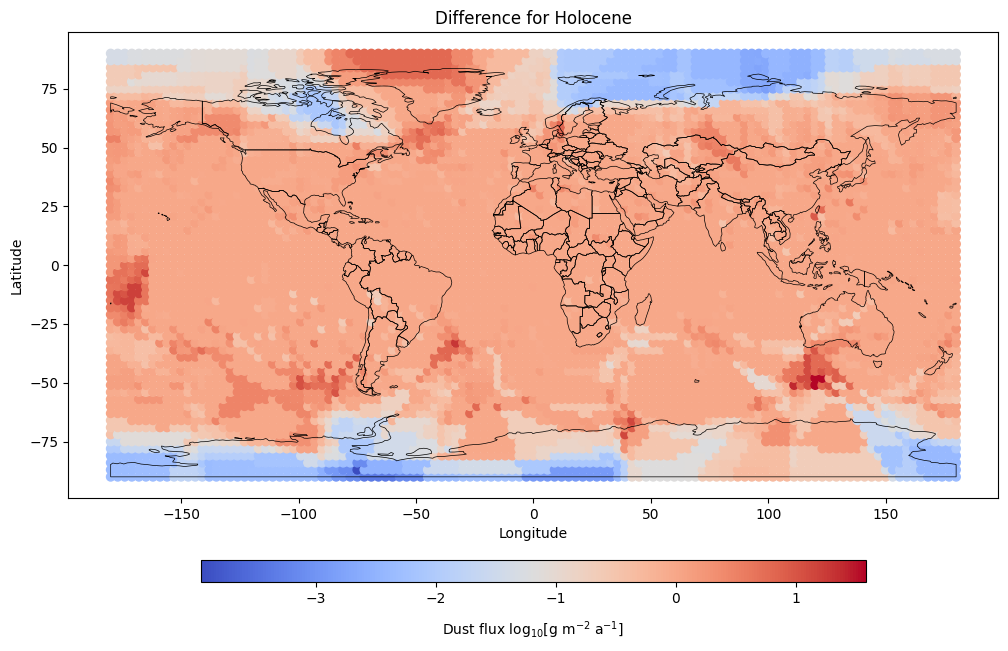

C:\Users\nsanc\AppData\Local\Temp\ipykernel_40032\1683112547.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


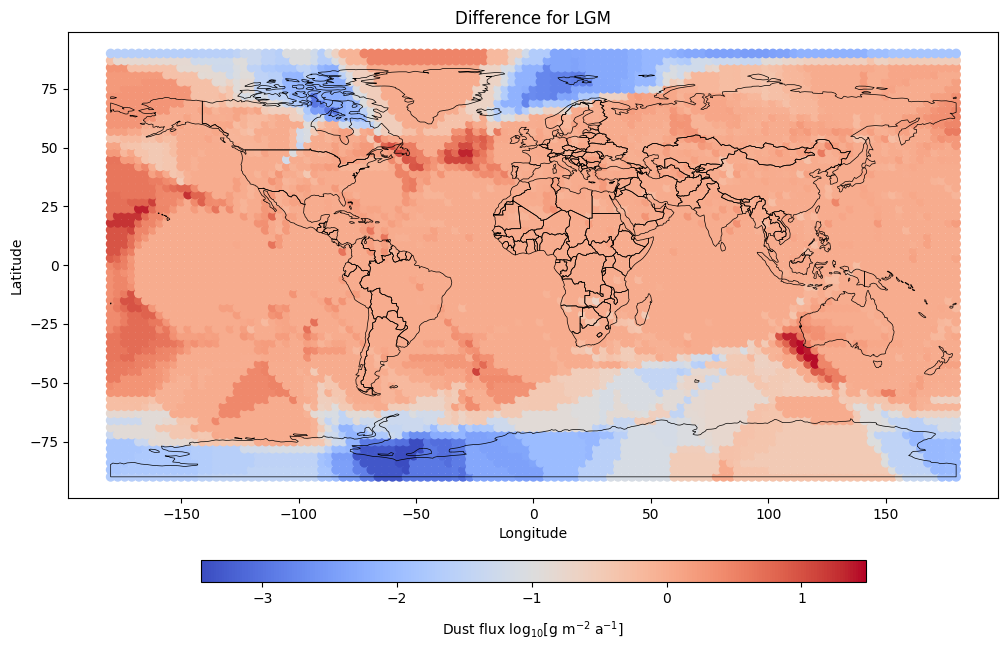

In [12]:
plot_differences(differences_holocene, 'Difference for Holocene', 'diff_geodesic_euclidean_holocene')
plot_differences(differences_lgm, 'Difference for LGM', 'diff_geodesic_euclidean_lgm')

En cuanto a por qué los resultados son diferentes, me centraría en la pregunta b y la pregunta d.
De mis búsquedas en Internet, podemos decir que las distancias geodésicas generalmente se consideran más precisas que las distancias euclidianas cuando se consideran ubicaciones de la Tierra como las regiones polares.Hay algo llamado "efecto de curvatura" en la Tierra. Debido a que la Tierra es una esfera aproximada (elipse), los cambios de curvatura de la Tierra son más obvios en las regiones polares. El cálculo de la distancia euclidiana se basa en la suposición de un plano. Para áreas que abarcan áreas grandes, especialmente en áreas con latitudes muy altas (como los polos norte y sur), los resultados del cálculo a menudo no pueden reflejar la distancia real de la superficie con mucha precisión.Los cálculos de distancias geodésicas tienen en cuenta la forma esférica de la Tierra y pueden proporcionar estimaciones de distancia más realistas en las regiones polares.
El Holoceno y el Último Máximo Glacial representan diferentes etapas de la Tierra, así como diferentes etapas climáticas y geográficas de la historia de la Tierra. Las diferencias entre estas dos etapas pueden ser factores que afecten mucho a los resultados.Al buscar información en línea, podemos encontrar que el clima durante el Último Máximo Glacial fue más frío que el Holoceno, y hubo capas de hielo más extensas en el hemisferio norte. Esta diferencia ambiental puede afectar la dirección y velocidad del viento, lo que a su vez afecta los patrones de transporte y deposición de polvo.Las diferencias en la cobertura de vegetación y el tipo de superficie entre los dos períodos pueden dar lugar a diferencias en las áreas donde se deposita el polvo, porque tanto la vegetación como la topografía pueden afectar la deposición de polvo.